### Part 5 makemore - Wavenet, Conv, Residual

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [5]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182580, 8]) torch.Size([182580])
torch.Size([22767, 8]) torch.Size([22767])
torch.Size([22799, 8]) torch.Size([22799])


In [6]:
for x, y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> e
.......e --> b
......eb --> r
.....ebr --> i
....ebri --> m
...ebrim --> a
..ebrima --> .
........ --> h
.......h --> i
......hi --> l
.....hil --> t
....hilt --> o
...hilto --> n
..hilton --> .
........ --> j
.......j --> h
......jh --> e
.....jhe --> n
....jhen --> e
...jhene --> .


In [ ]:
# pytorchifing the code yayayayaya

class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # kaiming init
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self): 
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -------------------

class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    # Input: (N, C) or (N, C, L), where N is the batch size, C is the number of features or channels, and L is the sequence length
    # Output: (N, C) or (N, C, L) (same shape as input)
    # Our BatchNorm1d is N, L, C, meaning C always last dim, so 
    # In official Torch BatchNorm1d, the input is (N, C, L) and ours is (N, L, C)
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0, 1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

# -------------------

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# -------------------
  
class Embedding:
  
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))
    
    def __call__(self, x):
        self.out = self.weight[x]
        return self.out
    
    def parameters(self):
        return [self.weight]

# -------------------

class FlattenConsecutive:

    def __init__(self, n):
        self.n = n

    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out
    
    def parameters(self):
        return []
  
# -------------------

class Sequential:
  
    def __init__(self, layers):
        self.layers = layers
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
  
    def parameters(self):
        # get parameters from all layers and stretch them out into a single list
        return [param for layer in self.layers for param in layer.parameters()]

In [40]:
# Let's Rock and write some more of our own pytorch code implementation 
# -------------------
import torch.nn as nn

class Conv1d:
   
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, is_casual=False):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size # save kernel size
        self.stride = stride
        self.padding = padding
        self.dilation = dilation # number of spaces between kernel elements (kernel holes)
        self.is_casual = is_casual

        # Initialize weight: shape (out_channels, in_channels, kernel_size)
        self.weight = torch.randn(out_channels, in_channels, kernel_size) / (in_channels * kernel_size)**0.5
        # Initialize bias: shape (out_channels,)
        self.bias = torch.zeros(out_channels) 
    
    def __call__(self, x):
        # calculate the forward pass
        # Expect x with shape: (N, L, C), where N is the batch size, L is the sequence length, and C is the number of channels
        N, L, C = x.shape

        # Calculate the effective kernel size taking dilation into account.
        effective_kernel_size = self.dilation * (self.kernel_size - 1) + 1

        # Determine the appropriate padding:
        if self.is_casual:
            # For causal convolutions, pad only on the left
            pad_amount = effective_kernel_size - 1
            pad = torch.zeros(N, pad_amount, C, dtype=x.dtype)
            x = torch.cat([pad, x], dim=1)
        else:
            # For symmetric padding on both sides.
            pad = torch.zeros(N, self.padding, C, dtype=x.dtype)
            x = torch.cat([pad, x, pad], dim=1)
        
        # New length after padding
        L_padded = x.shape[1]

        # Calculate the size of the output tensor after convolution
        out_size = (L_padded- effective_kernel_size) // self.stride + 1

        # Initialize the output tensor with zeros
        self.out = torch.zeros(N, out_size, self.out_channels, dtype=x.dtype)
        
        # Perform the convolution operation
        for i in range(out_size):
            # Determine slice indices on the time axis:
            start = i * self.stride
            end = start + effective_kernel_size  # end index (exclusive)
            # With dilation, extract every self.dilation-th element:
            # x_window shape: (N, kernel_size, C)
            x_window = x[:, start:end:self.dilation,:]
            # For each output channel, perform the convolution operation
            for j in range(self.out_channels):
                # Perform the convolution operation
                # self.weight[j] is (in_channels, kernel_size). We need (kernel_size, in_channels)
                weight_j = self.weight[j].transpose(0, 1)
                conv_sum = (x_window * weight_j.unsqueeze(0)).sum(dim=[1, 2])
                self.out[:, i, j] = conv_sum + self.bias[j]

        return self.out
    
    def parameters(self):
        return [self.weight, self.bias]

# -------------------
# if we want to use the pytorch Conv1d
class CasualConv1d:
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, is_casual=False):
        super().__init__()
        self.kernel_size = kernel_size
        self.dilation = dilation
        self.is_casual = is_casual
        self.padding = padding if not is_casual else dilation * (kernel_size - 1)
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, stride=stride, padding=self.padding, dilation=dilation)

    def forward(self, x):
        x = self.conv(x)
        if self.is_casual:
            x = x[:, :, : -self.padding] # remove padding
        return x

# -------------------

class Sigmoid:
  def __call__(self, x):
    self.out = torch.sigmoid(x)
    return self.out
  def parameters(self):
    return []

# -------------------

class Relu:
  def __call__(self, x):
    self.out = torch.relu(x)
    return self.out
  def parameters(self):
    return []

# -------------------


<img src="images/residual_skip_connections.png" width="800">

In [79]:
class WaveNetResidualBlock:
    
    def __init__(self, residual_channels, skip_channels, kernel_size, dilation):
        self.residual_channels = residual_channels
        self.skip_channels = skip_channels
        self.kernel_size = kernel_size
        self.dilation = dilation
        # Two causal dilated convolutions: one for filter, one for gate.
        self.conv_filter = Conv1d(residual_channels, 
                                  residual_channels, 
                                  kernel_size, 
                                  dilation=dilation, 
                                  is_casual=True)
        self.conv_gate = Conv1d(residual_channels, 
                                residual_channels, 
                                kernel_size, 
                                dilation=dilation, 
                                is_casual=True)
        # 1x1 convolutions for generating the residual and skip connections.
        self.conv_residual = Conv1d(residual_channels, 
                                    residual_channels,
                                    kernel_size=1, 
                                    is_casual=False)
        self.conv_skip = Conv1d(residual_channels,
                                 skip_channels,
                                 kernel_size=1, 
                                 is_casual=False)
    
    def __call__(self, x):
        # x shape assumed to be (batch, channels, time)
        # Apply causal dilated convolutions
        filter_output = self.conv_filter(x)
        gate_output = self.conv_gate(x)

        # Apply gated activation: combine tanh and sigmoid non-linearities
        gated_activation = torch.tanh(filter_output) * torch.sigmoid(gate_output)

        # 1x1 convolutions for residual and skip connections 
        residual_output = self.conv_residual(gated_activation)
        skip_output = self.conv_skip(gated_activation)

        # print('Residual shape:', residual_output.shape)
        # print('Skip shape:', skip_output.shape)
        # print('Input shape:', x.shape)

        # Add residual output to the input (skip connection)
        self.out = x + residual_output
         # Add residual output to the input (skip connection)n        self.out = x + residual_outputection)
        self.out = x + residual_output
        self.skip_out = skip_output
        return self.out, self.skip_out

    def parameters(self):
        # Flatten the returned lists.
        return (list(self.conv_filter.parameters()) + 
                list(self.conv_gate.parameters()) + 
                list(self.conv_residual.parameters()) + 
                list(self.conv_skip.parameters()))


# -------------------

class ModuleList:
    def __init__(self, modules=None):
        self.modules_list = [] if modules is None else list(modules)
    
    def append(self, module):
        self.modules_list.append(module)
    
    def __getitem__(self, idx):
        return self.modules_list[idx]
    
    def __len__(self):
        return len(self.modules_list)
    
    def __iter__(self):
        return iter(self.modules_list)
    
    def parameters(self):
        return [
            param
            for module in self.modules_list
            for param in module.parameters()
        ]

# -------------------

class WaveNetModel:

    def __init__(self, vocab_size, n_embd, dilations):
        
        self.embedding = Embedding(vocab_size, n_embd)
        # Create a list of residual blocks
        self.res_blocks = ModuleList(
            [WaveNetResidualBlock(n_embd, n_embd, kernel_size=2, dilation=d) for d in dilations]
        )
        # Use nn.Sequential for the final 1x1 convolutions and activations
        self.final_layers = Sequential([
            Relu(),
            Conv1d(n_embd, n_embd, kernel_size=1, is_casual=False),
            Relu(),
            Conv1d(n_embd, vocab_size, kernel_size=1, is_casual=False)
        ])
    
    def __call__(self, x):
        # x: (N, L) -> embed to (N, L, n_embd)
        x = self.embedding(x)
        skip_connections = []
        for res_block in self.res_blocks:
            x, skip = res_block(x)
            skip_connections.append(skip)
        # Sum the skip connections (each is of shape (N, L, n_embd))
        x = sum(skip_connections)
        x = self.final_layers(x)
        # For next-symbol prediction, take the last time step:
        logits = x[:, -1, :]  # shape: (N, vocab_size)
        return logits
    
    def parameters(self):
        return (list(self.embedding.parameters()) + 
                self.res_blocks.parameters() + 
                list(self.final_layers.parameters()))

In [80]:
torch.manual_seed(42); # seed rng for reproducibility

In [85]:
n_embd = 24 # the dimensionality of the character embedding vectors
n_hidden = 128 # the number of hidden units

dilations = [1,2,4]
model = WaveNetModel(vocab_size, n_embd, dilations)
parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True


12579


In [72]:
ix = torch.randint(0, Xtr.shape[0], (32,)) #lets look at the batch of just 4 examples
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([32, 8])


tensor([[13,  1, 18, 11,  5,  5, 19,  5],
        [ 0, 10,  5, 18, 18,  9,  1,  8],
        [ 0,  0,  0, 11,  5,  9,  1, 14],
        [ 0,  0,  0,  0,  0,  0, 10, 15],
        [ 0,  0,  0, 12,  5, 14, 14,  5],
        [ 0,  0,  0,  0,  0,  0,  0, 10],
        [ 0,  0,  0,  0,  8,  1, 26,  5],
        [ 0,  0,  0, 18,  1, 13,  5,  5],
        [ 0,  0,  0,  0,  8,  1, 14,  9],
        [ 0,  0,  0,  0,  0, 13,  1, 18],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  1],
        [ 0,  0,  0,  0,  1, 18, 14,  1],
        [ 0,  0, 13,  1,  7,  4,  1, 12],
        [ 0,  0,  0,  0,  1, 22,  1, 14],
        [ 0,  0,  0,  0,  0,  0, 18, 21],
        [ 0,  0,  0, 19, 15, 16,  8, 25],
        [ 0,  0,  0,  0, 12,  1, 20,  9],
        [ 0,  0,  0,  0,  0,  1, 14, 22],
        [ 0,  0,  0, 16,  1,  9, 12, 25],
        [ 0,  0, 11, 15, 12, 19, 25, 14],
        [ 0,  0,  0,  0,  0,  0,  0,  9],
        [ 0,  0,  0,  0, 11, 25, 1

In [87]:
# same optimization last time 
max_steps = 100000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))  # take random 32 examples to use in training
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # forward pass
    # emb = C[Xb] # [32,3,10] - embed characters into vectors
    # x = emb.view(emb.shape[0], -1) # concatenate the vectors - [32, 30]
    logits = model(Xb) # forward pass
    loss = F.cross_entropy(logits, Yb) #  loss function 
    
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update simple SGD
    lr = 0.1 if i < 50000 else 0.01 # step learning rate decay
    for p in model.parameters():
        if p.grad is not None:
            p.data += -lr * p.grad
    
    # track stats
    if i % 100 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    # if i >= 1000:
    #     break  # After DEBUG would take out obviously to run full optimisation 

      0/ 100000: 2.9380
    100/ 100000: 2.4731
    200/ 100000: 2.5995
    300/ 100000: 2.4558
    400/ 100000: 2.5252
    500/ 100000: 2.3277
    600/ 100000: 2.3727
    700/ 100000: 2.2075
    800/ 100000: 2.3141
    900/ 100000: 2.6917
   1000/ 100000: 2.3704
   1100/ 100000: 2.3219
   1200/ 100000: 2.5330
   1300/ 100000: 2.2310
   1400/ 100000: 2.4057
   1500/ 100000: 2.1598
   1600/ 100000: 2.3868
   1700/ 100000: 2.5764
   1800/ 100000: 2.5681
   1900/ 100000: 2.3867
   2000/ 100000: 1.9988
   2100/ 100000: 2.2853
   2200/ 100000: 2.4285
   2300/ 100000: 2.1251
   2400/ 100000: 2.1581
   2500/ 100000: 2.0500
   2600/ 100000: 2.3075
   2700/ 100000: 2.1227
   2800/ 100000: 2.0974
   2900/ 100000: 1.6380
   3000/ 100000: 1.9599
   3100/ 100000: 2.6506
   3200/ 100000: 2.4427
   3300/ 100000: 1.9681
   3400/ 100000: 2.3097
   3500/ 100000: 2.4839
   3600/ 100000: 2.4720
   3700/ 100000: 2.4520
   3800/ 100000: 2.0666
   3900/ 100000: 1.9664
   4000/ 100000: 2.3916
   4100/ 100000:

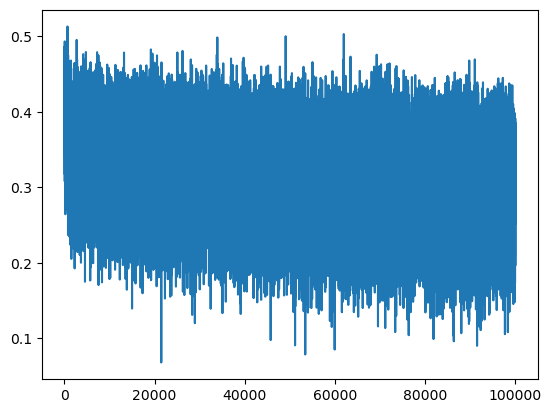

In [88]:
plt.plot(lossi)

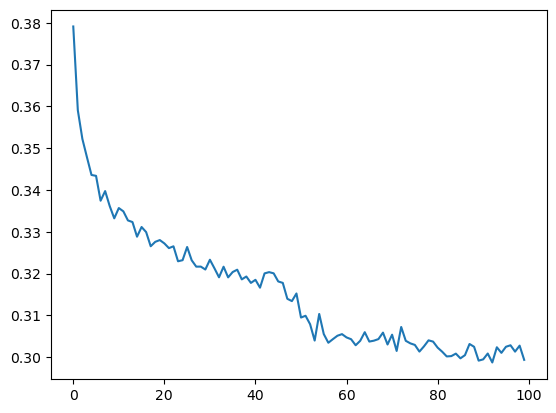

In [89]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [90]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0156314373016357
val 2.0746407508850098


In [91]:
# sample from the model
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context])) # (1,block_size) -> (1,vocab_size)
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

hacny.
erikley.
drvyn.
coro.
elice.
meeir.
kilsyn.
brylyn.
marcaana.
cold.
mainy.
linelle.
namirah.
kay.
janie.
dannon.
lyntanny.
abuola.
vintino.
briati.


#### OFFtopic

In [ ]:
class Conv1d:
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, 
                 padding=0, dilation=1, is_casual=False):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size   # kernel width in time dimension
        self.stride = stride
        self.padding = padding           # symmetric padding size (if not causal)
        self.dilation = dilation
        self.is_casual = is_casual

        # Weight shape: (out_channels, in_channels, kernel_size)
        self.weight = torch.randn(out_channels, in_channels, kernel_size) / (in_channels*kernel_size)**0.5
        # Bias shape: (out_channels,)
        self.bias = torch.zeros(out_channels)

    def __call__(self, x):
        # Expect x with shape: (N, in_channels, L)
        N, C, L = x.shape

        # Compute effective kernel size (taking dilation into account)
        effective_kernel_size = self.dilation * (self.kernel_size - 1) + 1

        # Apply padding along the time dimension (dim 2):
        if self.is_casual:
            # For causal convolution, pad only on the left.
            pad_amount = effective_kernel_size - 1
            pad = torch.zeros(N, C, pad_amount, dtype=x.dtype, device=x.device)
            x = torch.cat([pad, x], dim=2)
        else:
            # For symmetric padding (pad both left and right).
            pad_left = torch.zeros(N, C, self.padding, dtype=x.dtype, device=x.device)
            pad_right = torch.zeros(N, C, self.padding, dtype=x.dtype, device=x.device)
            x = torch.cat([pad_left, x, pad_right], dim=2)

        # New time length after padding:
        L_padded = x.shape[2]
        # Calculate output length (number of time steps): 
        L_out = (L_padded - effective_kernel_size) // self.stride + 1

        # Initialize output tensor: shape (N, out_channels, L_out)
        out = torch.zeros(N, self.out_channels, L_out, dtype=x.dtype, device=x.device)

        # Perform the convolution along the time dimension:
        for i in range(L_out):
            start = i * self.stride
            end = start + effective_kernel_size
            # With dilation, extract every self.dilation-th element along time axis.
            # x_window shape: (N, in_channels, kernel_size)
            x_window = x[:, :, start:end:self.dilation]
            # For each output channel compute the convolution:
            for j in range(self.out_channels):
                # weight[j] has shape: (in_channels, kernel_size)
                conv_sum = (x_window * self.weight[j]).sum(dim=[1, 2])
                out[:, j, i] = conv_sum + self.bias[j]

        return out

    def parameters(self):
        return [self.weight, self.bias]